In [2]:
import lost_ds as lds
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# Pathes

In [3]:
# pathes
IMG_PATH = os.path.expanduser('~/semi_tutorial/images')

GT_PARQUET_FILE_DETECTION = os.path.expanduser('~/semi_tutorial/ground_truth_open_image.parquet')

ANNO_DATA_PATH = os.path.expanduser('~/semi_tutorial/anno_data')
MODEL_DATA_PATH = os.path.expanduser('~/semi_tutorial/model_data')

# Configuration

In [4]:
GT_DS_ALL = lds.LOSTDataset(GT_PARQUET_FILE_DETECTION)
GT_DS_ALL.remap_img_path(new_root_path=IMG_PATH,
                    col='img_path',
                    inplace=True)

sns.set_theme()
sns.set(palette=['#034e7b', '#0570b0', '#3690c0', '#74a9cf', '#a6bddb', '#d0d1e6', '#f1eef6'])
sns.set_style("whitegrid", {'grid.linestyle': ':', 'axes.edgecolor': 'black'})
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'lmodern'
plt.rcParams['font.size'] = 11


LABEL_MAP = ['', 'hinzugefügt', 'gelöscht', 'geändert', 'Klasse\nvergeben', 'bewegt']

CM = 1/2.54

IMG_BATCH = 100

BAR_WIDTH = 0.8


# functions for evaluation

In [5]:
def collect_pred_parquet(parquet_path, type='detection'):
    '''
    parquet_path = path to dataset
    pred = False if model predictions
    '''
    if type == 'detection':
        img_path = IMG_PATH
        
    parquet = []
    for root, _, files in os.walk(parquet_path):
        files.sort()
        for file in files:
            if file.endswith(('.parquet')):
                parquet.append(os.path.join(root, file))
            
    parquet_ds = lds.LOSTDataset(parquet)
    parquet_ds.remap_img_path(new_root_path=img_path,
                        col='img_path',
                        inplace=True)
    
    if type == 'detection':
        parquet_ds.df.loc[:,'anno_confidence'] = 1
        parquet_ds.df = parquet_ds.df[parquet_ds.df['anno_data'].notna()]
        parquet_ds.df = parquet_ds.df[parquet_ds.df['anno_lbl'] != '']
                    
    return parquet_ds.df

def collect_model_parquet(model_parquet_path):
    parquet = []
    for root, _, files in os.walk(model_parquet_path):
        files.sort()
        for file in files:
            if file.endswith(('.parquet')):
                    parquet.append(os.path.join(root, file))
                    
    df_concat = []
    for idx, path in enumerate(parquet):
        ds = lds.LOSTDataset(path)
        ds.remap_img_path(new_root_path=IMG_PATH,
                            col='img_path',
                            inplace=True)
        ds.df.loc[:,'img_iteration'] = idx + 1
        df_concat.append(ds.df)
        
    return pd.concat(df_concat)

# collect the predicted images for eval with ground trouth
def adjust_gt_with_anno(pred):

    new_ds = GT_DS_ALL.copy()
        
    img_paths = pred['img_path'].unique().tolist()
    row_list = []
    for img_path in img_paths:
        found = new_ds.df[new_ds.df['img_path'] == img_path]
        row_list.append(found)
    new_ds.df = pd.concat(row_list)
    
    return new_ds.df

def to_1D(series):
    action_series = []
    for list in series:
        if list is not None:
            for action in list:
                action_series.append(action)
    return pd.Series(action_series)

def cast_action(actions):
    if actions['action'] == 'annoCreated':
        return 'Korrektur'
    if actions['action'] == 'annoDeleted':
        return 'Korrektur'
    else:
        return 'Zusätzliche' 

# count the actions of a dataset 
def get_action_df(df):
    df = df.drop_duplicates(subset=['img_path'])
    df = pd.DataFrame(to_1D(df['img_actions']).value_counts().reset_index().values, columns=['action', 'count'])
    df['type'] = df.apply(cast_action, axis=1)
    return df

# evaluate the mAP of model or participant prediction
def eval_mAP(pred):
    gt = adjust_gt_with_anno(pred)
    voc_eval = lds.voc_eval(gt, pred, iou_threshold=0.7)
    
    mAP = voc_eval['ap'].mean()
    mAP = int(mAP * 100)
    return mAP

# progress of action or time count for one participant to show in in a line plot
def progress(parquet_path, type, anno='detection'):

    collect_df = collect_pred_parquet(parquet_path, type=anno)
    dict_progress = {type: [],
                    'iter': []}

    for iteration in collect_df['img_iteration'].unique().tolist():
        df = collect_df[collect_df['img_iteration']==iteration]
        action_df = get_action_df(df)
        dict_progress['iter'].append(iteration + 1)
        
        number_of_images = len(df.drop_duplicates(subset=['img_path']).index)
        if type == 'action':
            mean = action_df['count'].sum() * IMG_BATCH / number_of_images
            dict_progress[type].append(mean)
            
        if type == 'img_time':
            df = df.drop_duplicates(subset=['img_path'])
            mean = df['img_anno_time'].mean()
            dict_progress[type].append(mean * IMG_BATCH / 60)
            
        if type == 'anno_time':
            df = df.drop_duplicates(subset=['img_path'])
            mean = df['anno_time'].mean()
            dict_progress[type].append(mean * IMG_BATCH / 60)
            

    return pd.DataFrame(dict_progress)

def get_mAP_progress(parquet, type):

    if type == 'model':
        progress_df = collect_model_parquet(parquet)
    if type == 'part':
        progress_df = collect_pred_parquet(parquet)
        
    dict_mAP = {'mAP': [],
                'iter': []}

    for idx in progress_df['img_iteration'].unique().tolist():
        dict_mAP['iter'].append(idx)
        
        found = progress_df[progress_df['img_iteration'] == idx]
        dict_mAP['mAP'].append(eval_mAP(found))
    
            
    return pd.DataFrame(dict_mAP)

def bboxes_iou(boxes1, boxes2):
    #boxes1 = np.array(boxes1)
    #boxes2 = np.array(boxes2)

    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    left_up       = np.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down    = np.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = np.maximum(right_down - left_up, 0.0)
    inter_area    = inter_section[..., 0] * inter_section[..., 1]
    union_area    = boxes1_area + boxes2_area - inter_area
    ious          = np.maximum(1.0 * inter_area / (union_area + 1e-7), np.finfo(np.float32).eps)
    ious          = ious
    return ious

def iou_mat(gt_list, pred_list):
    '''Calculate intersection matrix for gt boxes and prediction boxes

    Args:
        gt_list (np.array): List of ground truth boxes in LOST format (xc, yc, w, h)
        pred_list (np.array): List of predicted boxes in LOST format

    Returns:
        np.array: Array of shape (len(gt_list), len(pred_boxes))
            Each element represents the intersetion over union of two boxes.
    '''
    if gt_list is None or len(gt_list) == 0:
        return None
    if pred_list is None or len(pred_list) == 0:
        return None
        
    #1. find all overlaps for each box and save iou
        # in a matrix of (gt x pred)
    o_arr = np.zeros((len(gt_list), len(pred_list)))
    for idx_gt, bb_gt in enumerate(gt_list):
        for idx_pred, bb_pred in enumerate(pred_list):
            val = bboxes_iou(bb_gt, bb_pred)
            o_arr[idx_gt,idx_pred] = val
    return o_arr

def get_percent_reached_iou(anno_data):
    
    pred = collect_pred_parquet(anno_data)
    gt = adjust_gt_with_anno(pred)
    
    pred = lds.transform_bbox_style('x1y1x2y2', pred)
    gt = lds.transform_bbox_style('x1y1x2y2', gt)
    
    gt_number = gt.shape[0]
    
    pred_path = gt['img_path'].unique().tolist()
    
    count = 0
    
    for path in pred_path:
        
        pred_path = pred[pred['img_path'] == path]
        gt_path = gt[gt['img_path'] == path]
        
        pred_box_list = pred_path['anno_data'].tolist()
        gt_box_list = gt_path['anno_data'].tolist()

            
        mat = iou_mat(pred_box_list, gt_box_list)
        
        count += np.count_nonzero(mat > 0.70) 
    
    percent = (count / gt_number) * 100
    print('{:.1f}% of {} objects reach an iou of 70%'.format(percent, gt_number))

# Ground truth

In [6]:
# information ground truth
print('information detection dataset')
detections = GT_DS_ALL['anno_lbl'].value_counts()
print(detections)
print('number of objects = {}'.format(detections.sum()))
number_of_images = GT_DS_ALL['img_path'].unique().tolist()
print('number of images = {}'.format(len(number_of_images)))
print('average of {:.1f} objects per image'.format(detections.sum() / len(number_of_images)))

information detection dataset
[Person]      260
[Airplane]    130
[Fox]         116
[Bicycle]     103
[Bus]          80
Name: anno_lbl, dtype: int64
number of objects = 689
number of images = 443
average of 1.6 objects per image


# Evaluate annotation performance

process time in minutes
    img_time  iter
0  24.680097     1
1  17.501205     2
2  14.232990     3
3  12.233553     4
4  13.942775     5


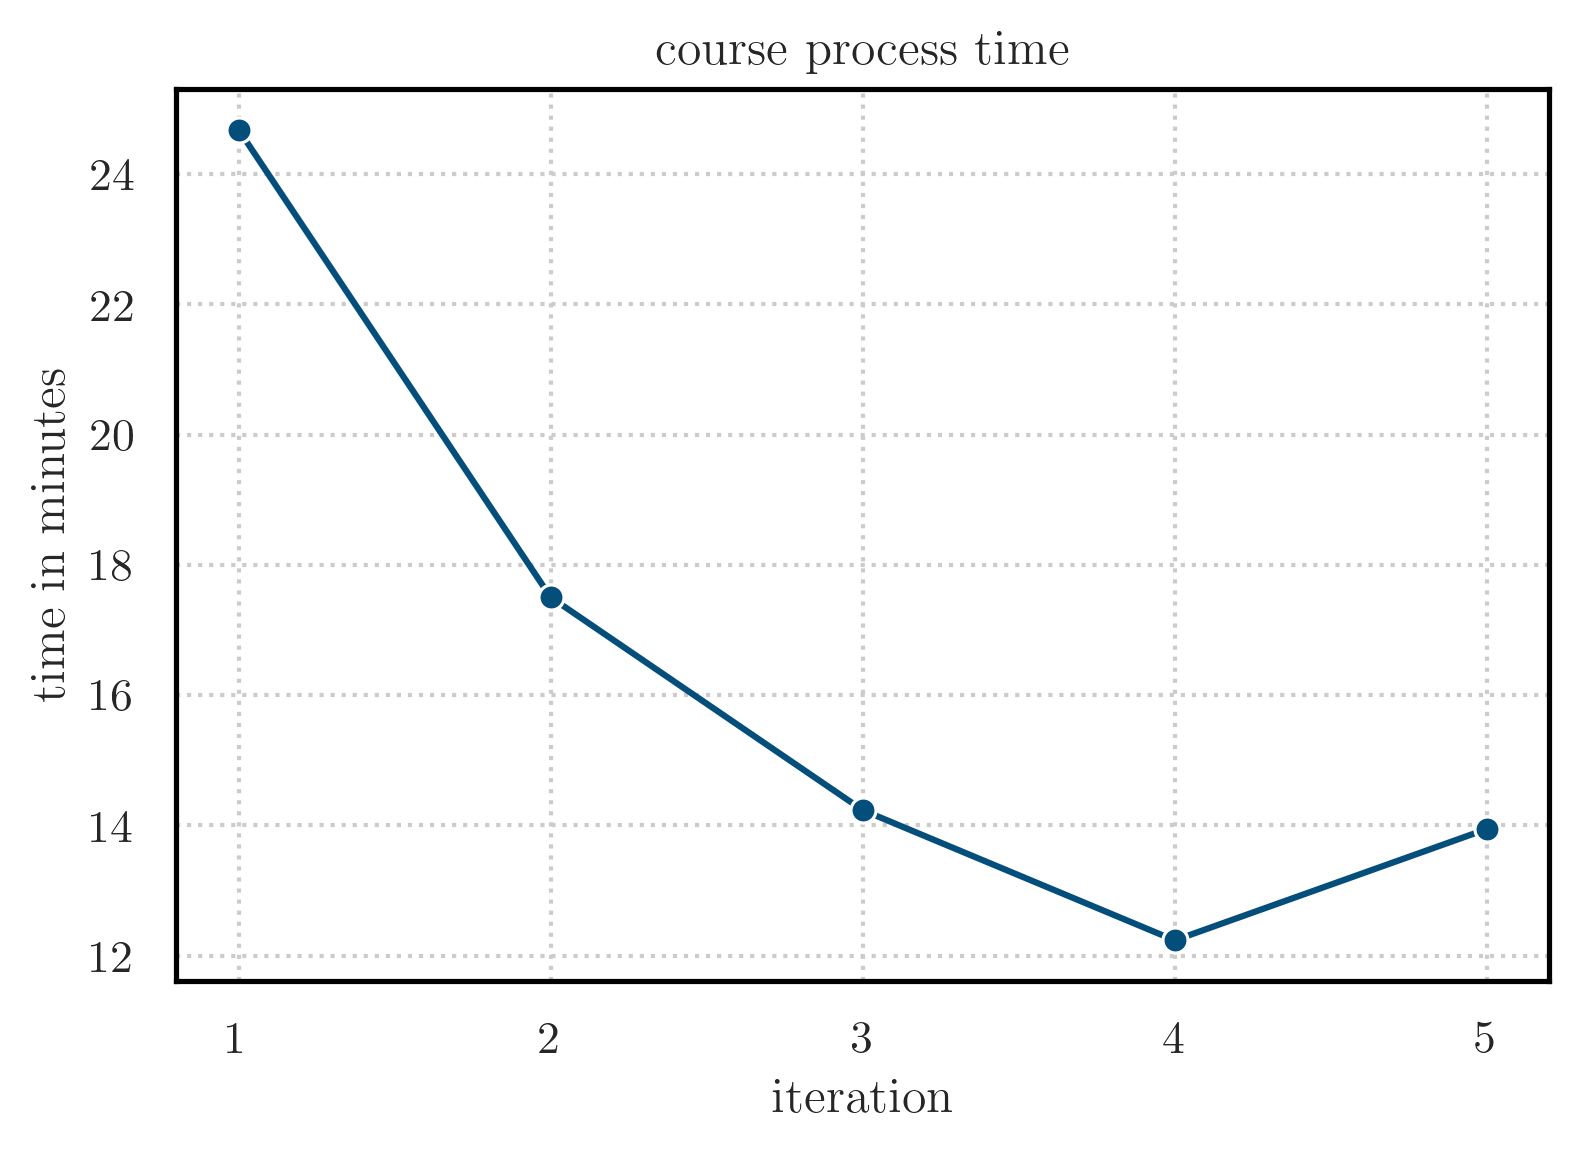

<Figure size 432x288 with 0 Axes>

In [8]:
# evaluate process time
# whole time for an image package (annotation iteration)
processing_time_eval = progress(ANNO_DATA_PATH, 'img_time', 'detection')

print('process time in minutes')
print(processing_time_eval)
fig, axes = plt.subplots(dpi=300, figsize=(15*CM,10*CM), sharey=True)
plt.title('course process time')

ax1 = sns.lineplot(x='iter', y='img_time',
             data=processing_time_eval,
             marker='o',
             #label= '$\it{Extreme\ Clicking}$ halbautomatisch',
             color='#034e7b')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.ylabel('time in minutes')
plt.xlabel('iteration')
plt.show()
plt.savefig(ANNO_DATA_PATH)

number of actions
       action  iter
0  445.000000     1
1  370.000000     2
2  331.000000     3
3  269.000000     4
4  320.930233     5


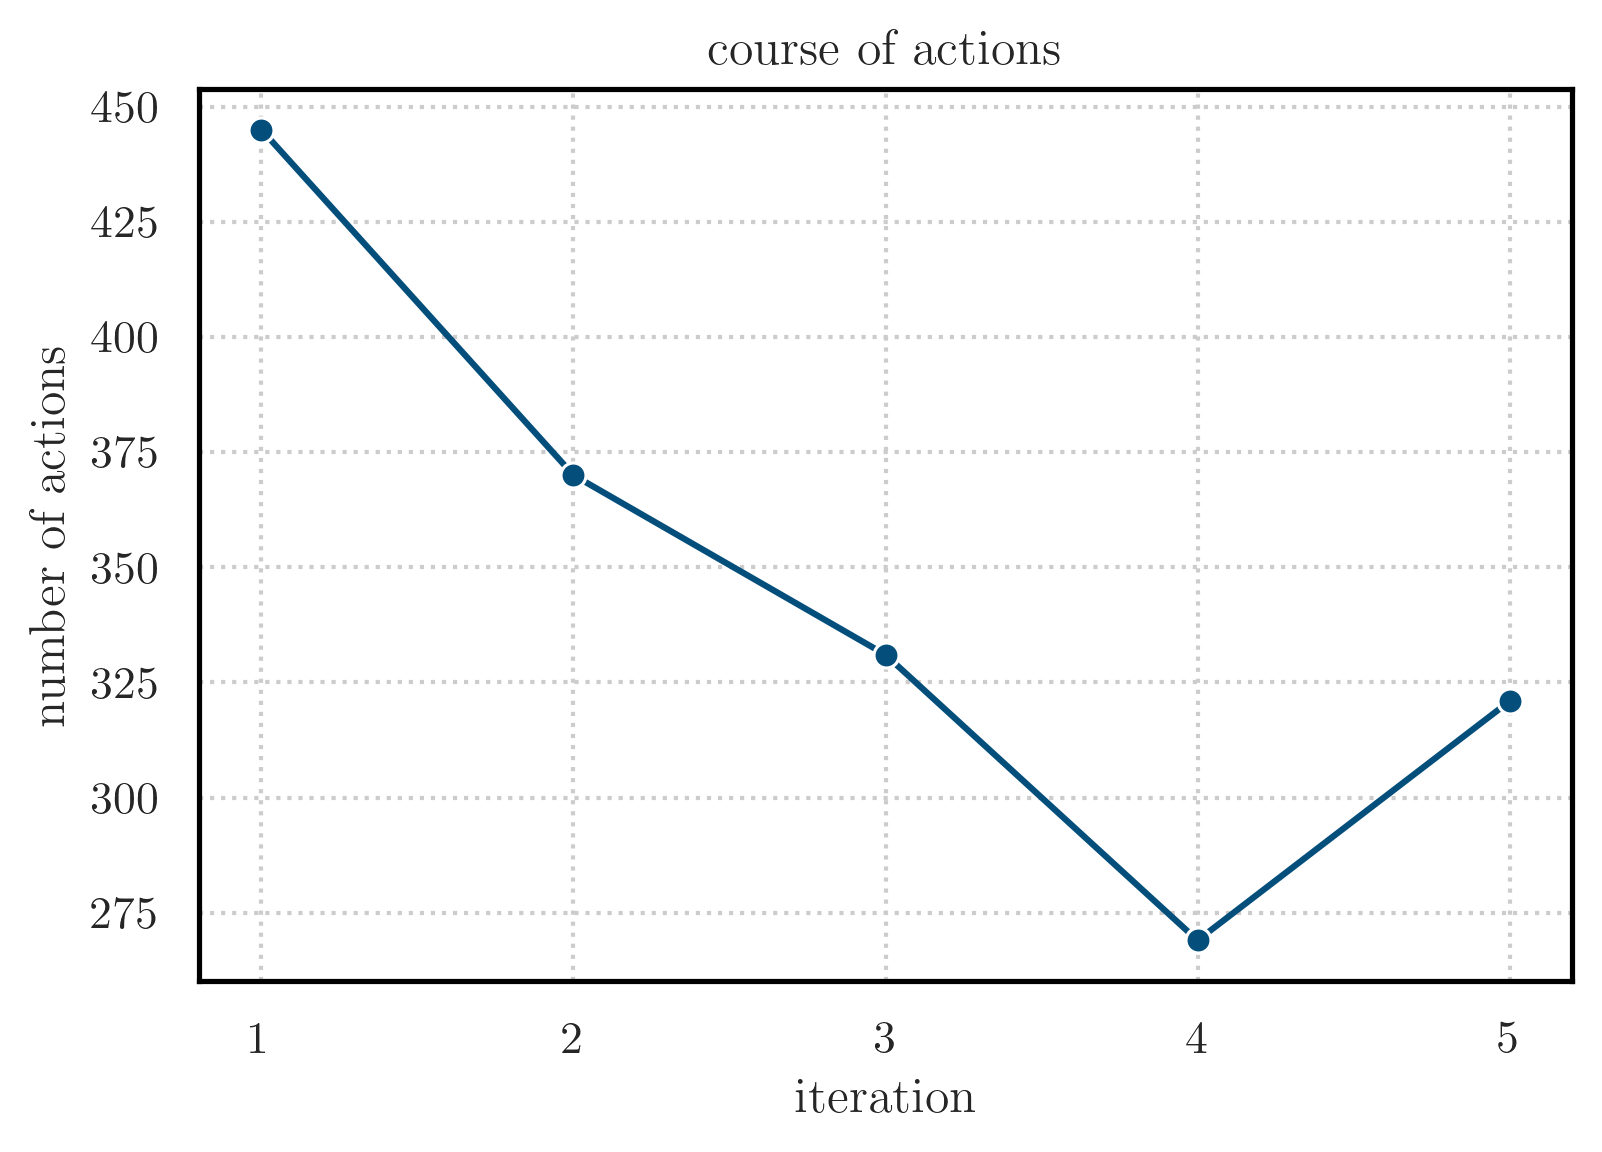

In [9]:
# evaluate number of actions
# actions are edit point, boxes ; move point, boxes ; create points , boxes ; add label ; delete points , boxes
action_eval = progress(ANNO_DATA_PATH, 'action', 'detection')

print('number of actions')
print(action_eval)
fig, axes = plt.subplots(dpi=300, figsize=(15*CM,10*CM), sharey=True)
plt.title('course of actions')

ax1 = sns.lineplot(x='iter', y='action',
             data=action_eval,
             marker='o',
             #label='$\it{Extreme\ Clicking}$ halbautomatisch',
             color='#034e7b')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.ylabel('number of actions')
plt.xlabel('iteration')
plt.show()

annotation time in minutes
   anno_time  iter
0   8.492480     1
1   7.094748     2
2   7.459019     3
3   7.065977     4
4   5.780742     5


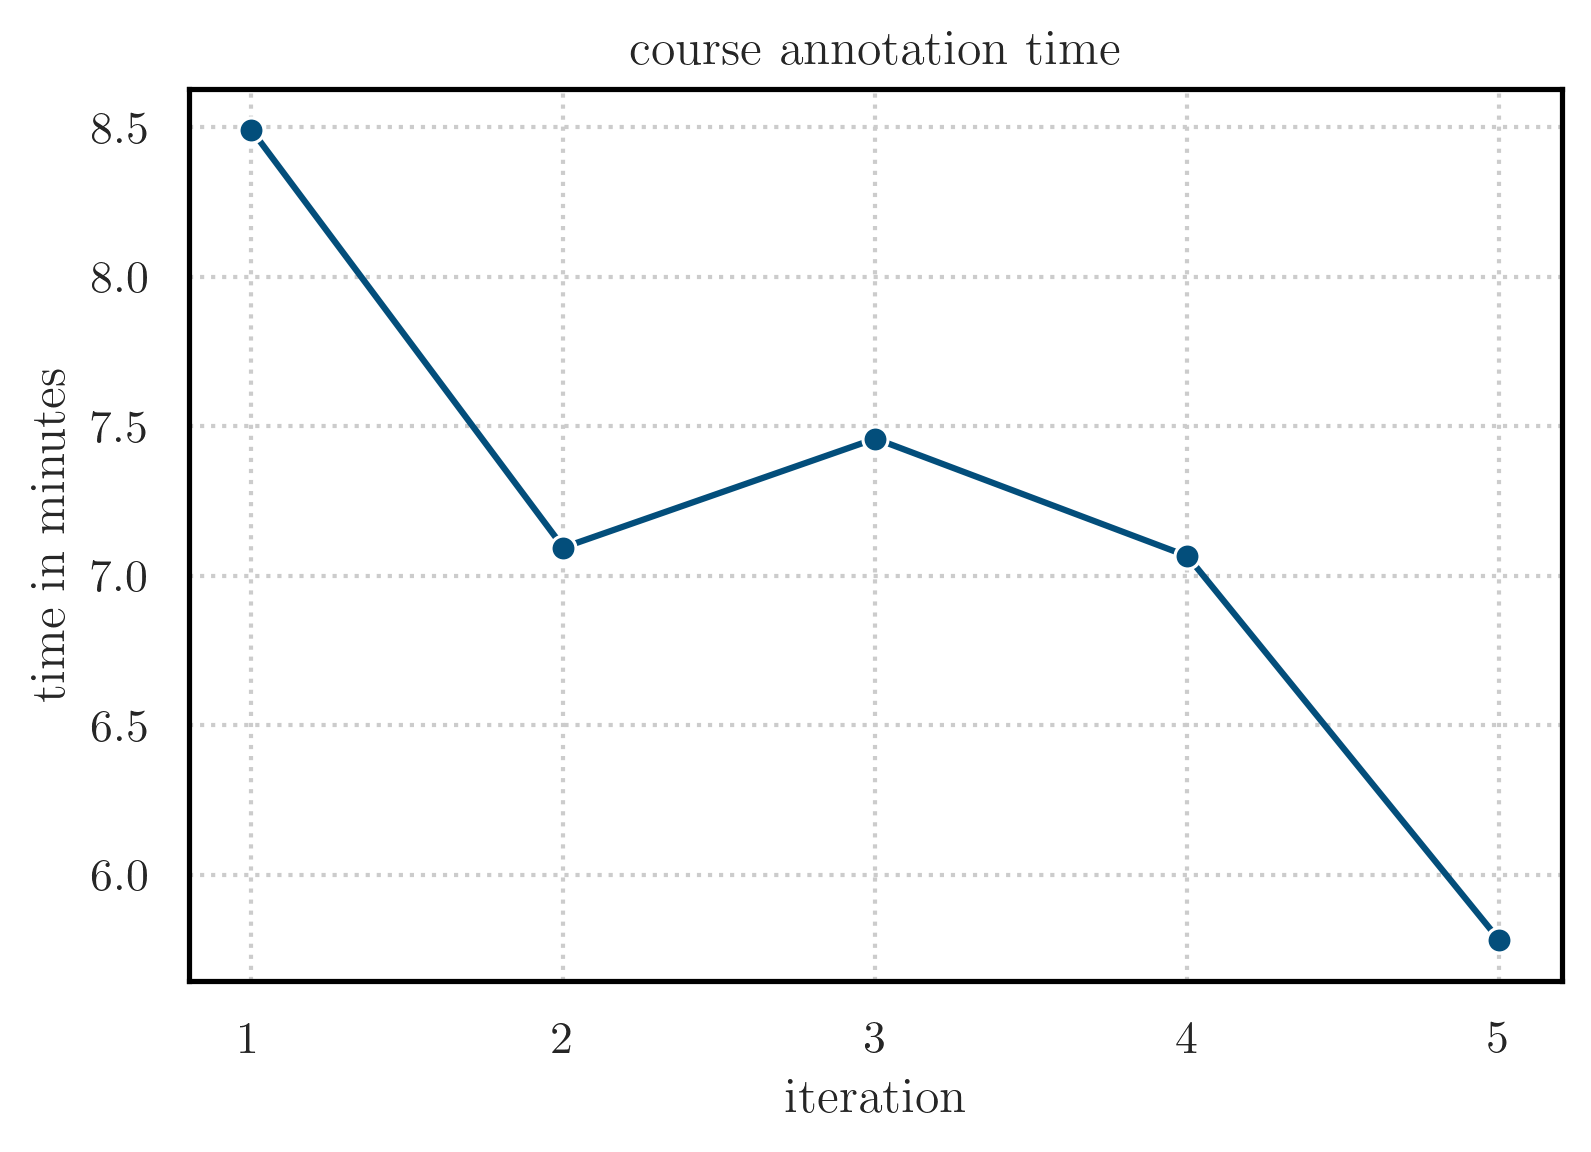

In [10]:
# evaluate annotation time
# the time of working
anno_time_eval = progress(ANNO_DATA_PATH, 'anno_time', 'detection')

print('annotation time in minutes')
print(anno_time_eval)
fig, axes = plt.subplots(dpi=300, figsize=(15*CM,10*CM), sharey=True)
plt.title('course annotation time')

ax1 = sns.lineplot(x='iter', y='anno_time',
             data=anno_time_eval,
             marker='o',
             #label='$\it{Extreme\ Clicking}$ halbautomatisch',
             color='#034e7b')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.ylabel('time in minutes')
plt.xlabel('iteration')
plt.show()

# Qualitiy

In [12]:
# mAP progression of the trained model
df = get_mAP_progress(MODEL_DATA_PATH, 'model')

print(df)
fig, axes = plt.subplots(dpi=300, figsize=(12*CM,10*CM), sharey=True)
ax = sns.lineplot(x='iter', y='mAP',
             data=df,
             marker='o')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.xlabel('train iteration')
plt.ylabel('mAP in \%')
plt.ylim(0)
plt.title('mAP model')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/dgacon/semi_tutorial/images/8ca2545596ef8c4d.jpg'

   mAP  iter
0   90     0
1   80     1
2   75     2
3   69     3
4   80     4


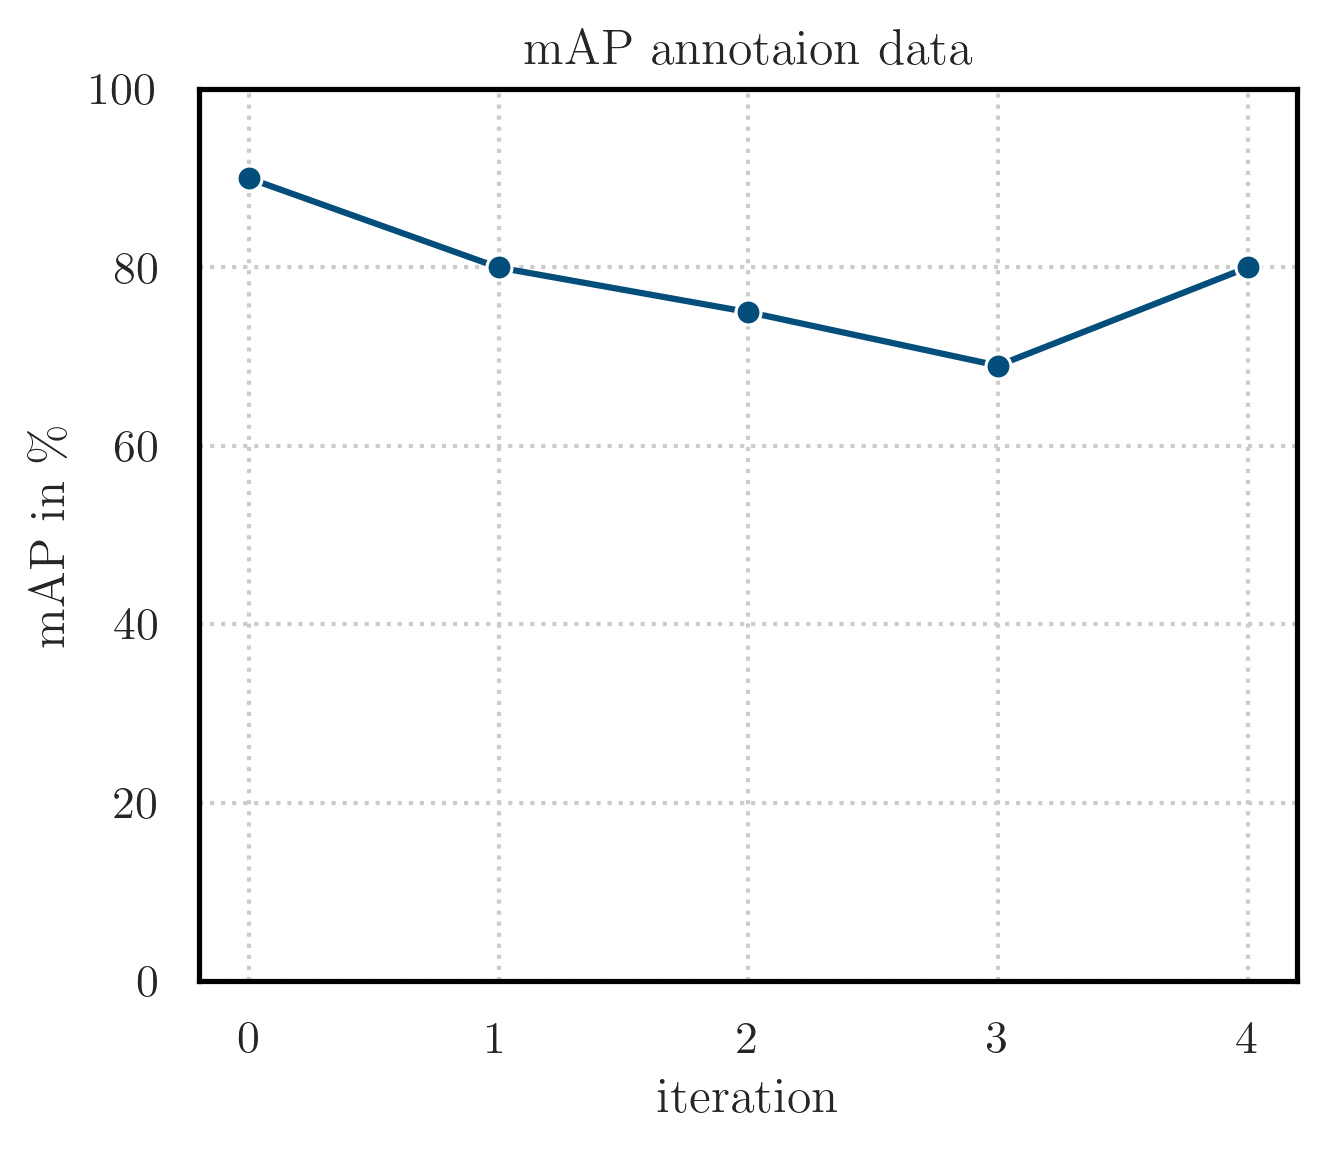

In [ ]:
# mAP progression of the annotated data
df = get_mAP_progress(ANNO_DATA_PATH, 'part')
print(df)
fig, axes = plt.subplots(dpi=300, figsize=(12*CM,10*CM), sharey=True)
ax = sns.lineplot(x='iter', y='mAP',
             data=df,
             marker='o')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.xlabel('iteration')
plt.ylabel('mAP in \%')
plt.ylim(0,100)
plt.title('mAP annotaion data')
plt.show()

# check iou of participants

In [ ]:
# how many boxes reach the iou of 70%
get_percent_reached_iou(ANNO_DATA_PATH)

84.3% of 689 objects reach an iou of 70%
